In [1]:
#!pip install easyocr
#!pip install imutils
#install pytorch

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import easyocr

## Convert to Grayscale

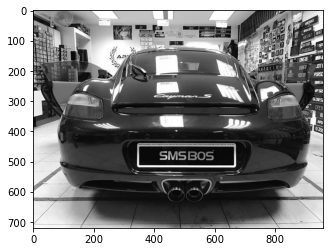

In [2]:
img = cv2.imread('plat1.jpg')
grayscale = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(grayscale,cv2.COLOR_BGR2RGB))

Images are converted to Grayscale to reduce dimension (RGB have 3 channels and dimension while grayscale images are single-dimensional). In addition to that, many algorithms are customized to work only on grayscale images for example the Canny edge detection function pre-implemented in OpenCV library.

## Filter and Find Edges

Preprocess the image so that only the car registration plate is passed to EasyOCR.

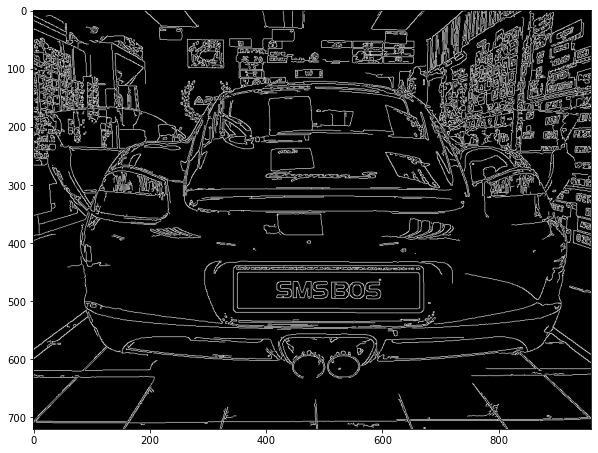

In [3]:
fig = plt.figure(figsize=(10,10))
b_filter = cv2.bilateralFilter(grayscale,11,17,17)
edged = cv2.Canny(b_filter,30,200)
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))

## Contour Detection

In [4]:
k_points = cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(k_points)
contours = sorted(contours, key=cv2.contourArea,reverse=True)[:10]

There are three arguments in cv.findContours() function, first one is source image, second is contour retrieval mode, third is contour approximation method. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

In [5]:
plate_location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour,9,True)
    if len(approx) == 4:
        plate_location = approx
        break

cv2.approxPolyDP approximates a curve or a polygon with another curve or polygon with less vertices so that the distance between them is less or equal to the specified precision. It uses the Douglas-Peucker algorithm (further read http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm).

In [6]:
plate_location

array([[[344, 446]],

       [[348, 519]],

       [[672, 514]],

       [[665, 439]]], dtype=int32)

## View Masked Detection

In [7]:
mask = np.zeros(grayscale.shape,np.uint8)
new_image = cv2.drawContours(mask, [plate_location],0,255,-1)
new_image = cv2.bitwise_and(img,img,mask=mask)

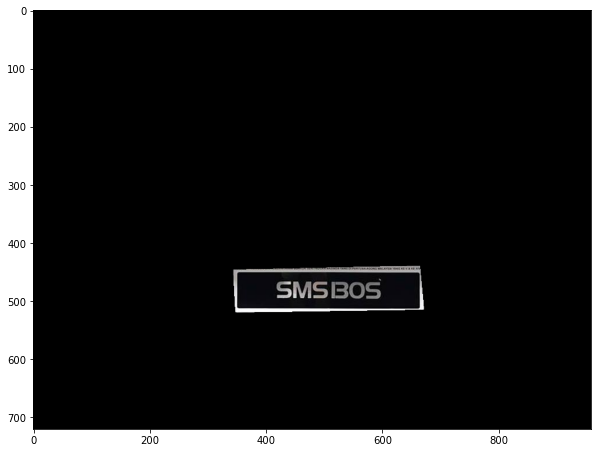

In [8]:
fig = plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

In [9]:
(x,y) = np.where(mask==255)
(x1,y1) = (np.min(x),np.min(y))
(x2,y2) = (np.max(x),np.max(y))
img_crop = grayscale[x1:x2+1,y1:y2+1]

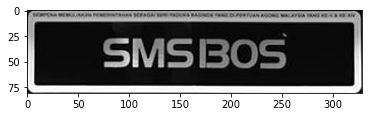

In [10]:
plt.imshow(cv2.cvtColor(img_crop,cv2.COLOR_BGR2RGB))

After all the preprocessing done, we can now run EasyOCR on the picture.

In [11]:
read_plate = easyocr.Reader(['en'])
result = read_plate.readtext(img_crop)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\Haziq\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
result

[([[67, 21], [261, 21], [261, 63], [67, 63]], 'SmsBOs', 0.29163605857093866)]

## Render to original image

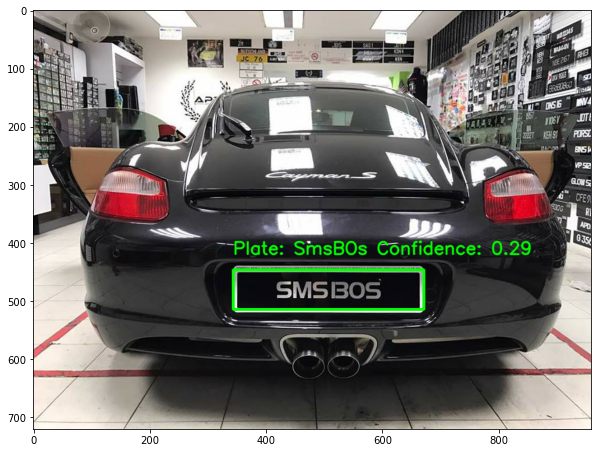

In [13]:
fig = plt.figure(figsize=(10,10))

plate_text = str(result[0][-2])
confidence = str(round((result[0][-1]), 2))


text = str('Plate: '+(plate_text)+' Confidence: '+ str(confidence))
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]-100), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

Here we have it, a simple car plate number recognition using EasyOCR and OpenCV. Very convenient.